In [1]:
import numpy as np
import pandas as pd
import h5py
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchinfo import summary
from typing import Tuple, Optional
import os 
import torch.utils.checkpoint as checkpoint
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm, trange
import seaborn as sns
import gc
import pywt 
import time 
import time
import warnings
from collections import deque
import psutil
import os
import warnings
import math 
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### **CONFIGURATION** 

In [3]:
FILE_PATH = "C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\GOLD_XYZ_OSC.0001_1024.hdf5"
JSON_PATH = 'C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\classes-fixed.json'

# Focused experiment setup
TARGET_MODULATIONS = ['8PSK', '16QAM']  # Only 2 modulations
TARGET_SNRS = [
                -6, 6, 
               18]  # Low, Medium, High SNR

# Processing options
FEATURE_METHOD = 'amplitude_phase'  # Options: 'amplitude_phase', 'iq_wavelets', 'fft_wavelets'
OUTPUT_DIR = './aplitude_wavelet_xperiment'  # Directory for results
TRAIN_RATIO = 0.8
VALID_RATIO = 0.2

# Wavelet settings (if using wavelet methods)
WAVELET_NAME = 'cmor1.5-1.0'  # For CWT
NUM_SCALES = 64  # Reduced for speed
TARGET_SIZE = 32  # Output image size (32x32)

print(f"🎯 Focused Experiment Setup:")
print(f"   Modulations: {TARGET_MODULATIONS}")
print(f"   SNR levels: {TARGET_SNRS}")
print(f"   Feature method: {FEATURE_METHOD}")
print(f"   Output directory: {OUTPUT_DIR}")

🎯 Focused Experiment Setup:
   Modulations: ['8PSK', '16QAM']
   SNR levels: [-6, 6, 18]
   Feature method: amplitude_phase
   Output directory: ./aplitude_wavelet_xperiment


### **DATA LOADING**

In [30]:
def load_and_filter_data():
    """Load RadioML data and filter for target modulations and SNRs."""
    
    print("📂 Loading and filtering RadioML data...")
    
    # Load files
    h5_file = h5py.File(FILE_PATH, 'r')
    with open(JSON_PATH, 'r') as f:
        modulation_classes = json.load(f)
    
    # Load arrays
    X = h5_file['X']  # Shape: (samples, 1024, 2)
    Y = np.argmax(h5_file['Y'], axis=1)  # Labels
    Z = h5_file['Z'][:, 0]  # SNRs
    
    print(f"   Original dataset: {X.shape[0]} samples")
    
    # Get target modulation indices
    target_mod_indices = [modulation_classes.index(mod) for mod in TARGET_MODULATIONS]
    print(f"   Target modulation indices: {dict(zip(TARGET_MODULATIONS, target_mod_indices))}")
    
    # Filter for target modulations and SNRs
    mask = np.zeros(len(Y), dtype=bool)
    
    for mod_idx in target_mod_indices:
        for snr in TARGET_SNRS:
            condition = (Y == mod_idx) & (Z == snr)
            mask |= condition
            count = np.sum(condition)
            mod_name = TARGET_MODULATIONS[target_mod_indices.index(mod_idx)]
            print(f"   {mod_name} at {snr}dB: {count} samples")
    
    # Apply filter
    X_filtered = X[mask]
    Y_filtered = Y[mask]
    Z_filtered = Z[mask]
    
    # Remap labels to 0, 1
    label_mapping = {}
    for new_label, old_label in enumerate(target_mod_indices):
        Y_filtered[Y_filtered == old_label] = new_label
        label_mapping[old_label] = new_label
    
    print(f"✅ Filtered dataset: {X_filtered.shape[0]} samples")
    print(f"   Label mapping: {label_mapping}")
    
    h5_file.close()
    return X_filtered, Y_filtered, Z_filtered, label_mapping

### **FEATURE EXTRACTION METHODS**

In [31]:
def extract_amplitude_phase_features(i_signal, q_signal):
    """Simple amplitude/phase feature extraction."""
    
    # Calculate amplitude and phase
    amplitude = np.sqrt(i_signal**2 + q_signal**2)
    phase = np.arctan2(q_signal, i_signal)
    
    # Reshape to 32x32
    amp_2d = resize_to_32x32(amplitude)
    phase_2d = resize_to_32x32(phase)
    
    return amp_2d.astype(np.float32), phase_2d.astype(np.float32)

def extract_iq_wavelet_features(i_signal, q_signal):
    """I/Q channel wavelet feature extraction."""
    
    # Setup scales
    signal_length = len(i_signal)
    scales = np.logspace(0, np.log10(signal_length//4), NUM_SCALES)
    
    # Apply CWT to I and Q separately
    wavelet_real = 'morl'  # Real wavelet for I/Q channels
    coeffs_i, _ = pywt.cwt(i_signal, scales, wavelet_real)
    coeffs_q, _ = pywt.cwt(q_signal, scales, wavelet_real)
    
    # Reshape to 32x32
    i_2d = resize_to_32x32(np.abs(coeffs_i))  # Take magnitude
    q_2d = resize_to_32x32(np.abs(coeffs_q))
    
    return i_2d.astype(np.float32), q_2d.astype(np.float32)

def extract_fft_wavelet_features(i_signal, q_signal):
    """FFT + 2D wavelet hybrid approach."""
    
    # FFT stage
    complex_signal = i_signal + 1j * q_signal
    fft_result = np.fft.fft(complex_signal)
    
    # Extract real and imaginary parts
    fft_real = np.real(fft_result)
    fft_imag = np.imag(fft_result)
    
    # Reshape to 32x32 images
    real_2d = resize_to_32x32(fft_real)
    imag_2d = resize_to_32x32(fft_imag)
    
    # Apply 2D wavelets to these "frequency images"
    # Using simple 2D wavelet decomposition
    coeffs_real = pywt.dwt2(real_2d, 'db4')
    coeffs_imag = pywt.dwt2(imag_2d, 'db4')
    
    # Reconstruct to maintain 32x32 size
    real_wavelet = pywt.idwt2(coeffs_real, 'db4')
    imag_wavelet = pywt.idwt2(coeffs_imag, 'db4')
    
    # Ensure 32x32 size
    real_final = resize_to_32x32(real_wavelet)
    imag_final = resize_to_32x32(imag_wavelet)
    
    return real_final.astype(np.float32), imag_final.astype(np.float32)

def resize_to_32x32(signal_1d_or_2d):
    """Resize any 1D or 2D array to 32x32."""
    
    if signal_1d_or_2d.ndim == 1:
        # 1D signal: reshape to 2D first
        signal_length = len(signal_1d_or_2d)
        # Find closest factors to make rectangular
        h = int(np.sqrt(signal_length))
        while signal_length % h != 0 and h > 1:
            h -= 1
        w = signal_length // h
        signal_2d = signal_1d_or_2d[:h*w].reshape(h, w)
    else:
        signal_2d = signal_1d_or_2d
    
    # Resize to 32x32
    h, w = signal_2d.shape
    
    # Simple decimation/interpolation
    h_indices = np.linspace(0, h-1, 32).astype(int)
    w_indices = np.linspace(0, w-1, 32).astype(int)
    
    resized = signal_2d[np.ix_(h_indices, w_indices)]
    
    # Ensure exactly 32x32
    if resized.shape != (32, 32):
        # Pad or crop as needed
        result = np.zeros((32, 32), dtype=signal_2d.dtype)
        min_h = min(32, resized.shape[0])
        min_w = min(32, resized.shape[1])
        result[:min_h, :min_w] = resized[:min_h, :min_w]
        return result
    
    return resized

In [32]:
def preprocess_focused_dataset():
    """Main preprocessing pipeline for focused experiment."""
    
    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Load and filter data
    X_filtered, Y_filtered, Z_filtered, label_mapping = load_and_filter_data()
    
    total_samples = len(X_filtered)
    print(f"\n🌊 Processing {total_samples} samples with {FEATURE_METHOD} method...")
    
    # Select feature extraction method
    if FEATURE_METHOD == 'amplitude_phase':
        extract_features = extract_amplitude_phase_features
        feature_names = ['amplitude', 'phase']
    elif FEATURE_METHOD == 'iq_wavelets':
        extract_features = extract_iq_wavelet_features
        feature_names = ['i_wavelet', 'q_wavelet']
    elif FEATURE_METHOD == 'fft_wavelets':
        extract_features = extract_fft_wavelet_features
        feature_names = ['fft_real_wavelet', 'fft_imag_wavelet']
    else:
        raise ValueError(f"Unknown feature method: {FEATURE_METHOD}")
    
    # Process all samples
    start_time = time.time()
    
    feature1_list = []
    feature2_list = []
    labels_list = []
    snrs_list = []
    
    for i in tqdm(range(total_samples), desc="Processing samples"):
        # Extract I/Q signals
        i_signal = X_filtered[i, :, 0]
        q_signal = X_filtered[i, :, 1]
        
        # Apply feature extraction
        feature1, feature2 = extract_features(i_signal, q_signal)
        
        # Store results
        feature1_list.append(feature1)
        feature2_list.append(feature2)
        labels_list.append(Y_filtered[i])
        snrs_list.append(Z_filtered[i])
    
    # Convert to numpy arrays
    features1 = np.array(feature1_list)
    features2 = np.array(feature2_list)
    labels = np.array(labels_list)
    snrs = np.array(snrs_list)
    
    processing_time = time.time() - start_time
    print(f"✅ Processing complete in {processing_time/60:.1f} minutes")
    print(f"   Features shape: {features1.shape}, {features2.shape}")
    print(f"   Speed: {total_samples/processing_time:.1f} samples/second")
    
    # Create train/valid splits
    create_train_valid_splits(features1, features2, labels, snrs, feature_names)
    
    return features1, features2, labels, snrs

def create_train_valid_splits(features1, features2, labels, snrs, feature_names):
    """Create train/validation splits and save to HDF5."""
    
    print(f"\n📊 Creating train/validation splits...")
    
    # Stratified split to maintain modulation/SNR balance
    train_indices = []
    valid_indices = []
    
    # Split by modulation and SNR combination
    for mod_label in [0, 1]:  # 8PSK=0, 16QAM=1
        for snr in TARGET_SNRS:
            # Find samples for this combination
            mask = (labels == mod_label) & (snrs == snr)
            indices = np.where(mask)[0]
            
            # Shuffle and split
            np.random.shuffle(indices)
            split_point = int(TRAIN_RATIO * len(indices))
            
            train_indices.extend(indices[:split_point])
            valid_indices.extend(indices[split_point:])
    
    train_indices = np.array(train_indices)
    valid_indices = np.array(valid_indices)
    
    print(f"   Train samples: {len(train_indices)}")
    print(f"   Valid samples: {len(valid_indices)}")
    
    # Save train split
    save_split('train', train_indices, features1, features2, labels, snrs, feature_names)
    
    # Save validation split
    save_split('valid', valid_indices, features1, features2, labels, snrs, feature_names)

def save_split(split_name, indices, features1, features2, labels, snrs, feature_names):
    """Save a data split to HDF5 file."""
    
    output_file = os.path.join(OUTPUT_DIR, f'{split_name}_{FEATURE_METHOD}.h5')
    
    with h5py.File(output_file, 'w') as f:
        # Save features
        f.create_dataset('feature1', data=features1[indices], compression='gzip')
        f.create_dataset('feature2', data=features2[indices], compression='gzip')
        f.create_dataset('labels', data=labels[indices])
        f.create_dataset('snrs', data=snrs[indices])
        
        # Save metadata
        f.attrs['num_samples'] = len(indices)
        f.attrs['feature_method'] = FEATURE_METHOD.encode('utf-8')
        f.attrs['feature1_name'] = feature_names[0].encode('utf-8')
        f.attrs['feature2_name'] = feature_names[1].encode('utf-8')
        f.attrs['modulations'] = [mod.encode('utf-8') for mod in TARGET_MODULATIONS]
        f.attrs['target_snrs'] = TARGET_SNRS
        f.attrs['num_classes'] = 2
    
    file_size = os.path.getsize(output_file) / (1024**2)  # MB
    print(f"   {split_name}: {output_file} ({file_size:.1f} MB)")

In [33]:
features1, features2, labels, snrs = preprocess_focused_dataset()

📂 Loading and filtering RadioML data...
   Original dataset: 2555904 samples
   Target modulation indices: {'8PSK': 5, '16QAM': 12}
   8PSK at -6dB: 4096 samples
   8PSK at 6dB: 4096 samples
   8PSK at 18dB: 4096 samples
   16QAM at -6dB: 4096 samples
   16QAM at 6dB: 4096 samples
   16QAM at 18dB: 4096 samples
✅ Filtered dataset: 24576 samples
   Label mapping: {5: 0, 12: 1}

🌊 Processing 24576 samples with amplitude_phase method...


Processing samples: 100%|█████████████████████████████████████████████████████| 24576/24576 [00:01<00:00, 21979.59it/s]


✅ Processing complete in 0.0 minutes
   Features shape: (24576, 32, 32), (24576, 32, 32)
   Speed: 20967.1 samples/second

📊 Creating train/validation splits...
   Train samples: 19656
   Valid samples: 4920
   train: ./aplitude_wavelet_xperiment\train_amplitude_phase.h5 (138.6 MB)
   valid: ./aplitude_wavelet_xperiment\valid_amplitude_phase.h5 (34.8 MB)


In [34]:
def visualize_samples():
    """Visualize sample features to verify processing."""
    
    print(f"\n🔍 Visualizing sample features...")
    
    # Load train data
    train_file = os.path.join(OUTPUT_DIR, f'train_{FEATURE_METHOD}.h5')
    
    with h5py.File(train_file, 'r') as f:
        features1 = f['feature1'][:10]  # First 10 samples
        features2 = f['feature2'][:10]
        labels = f['labels'][:10]
        snrs = f['snrs'][:10]
        
        feature1_name = f.attrs['feature1_name']
        feature2_name = f.attrs['feature2_name']
    
    # Plot samples
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    for i in range(5):
        # Feature 1
        axes[0, i].imshow(features1[i], cmap='viridis')
        mod_name = TARGET_MODULATIONS[labels[i]]
        axes[0, i].set_title(f'{feature1_name}\n{mod_name} ({snrs[i]:.0f}dB)')
        
        # Feature 2
        axes[1, i].imshow(features2[i], cmap='hsv' if 'phase' in feature2_name else 'viridis')
        axes[1, i].set_title(f'{feature2_name}\n{mod_name} ({snrs[i]:.0f}dB)')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'sample_features_{FEATURE_METHOD}.png'), dpi=150)
    plt.show()
    
    print(f"✅ Sample visualization saved")


🔍 Visualizing sample features...


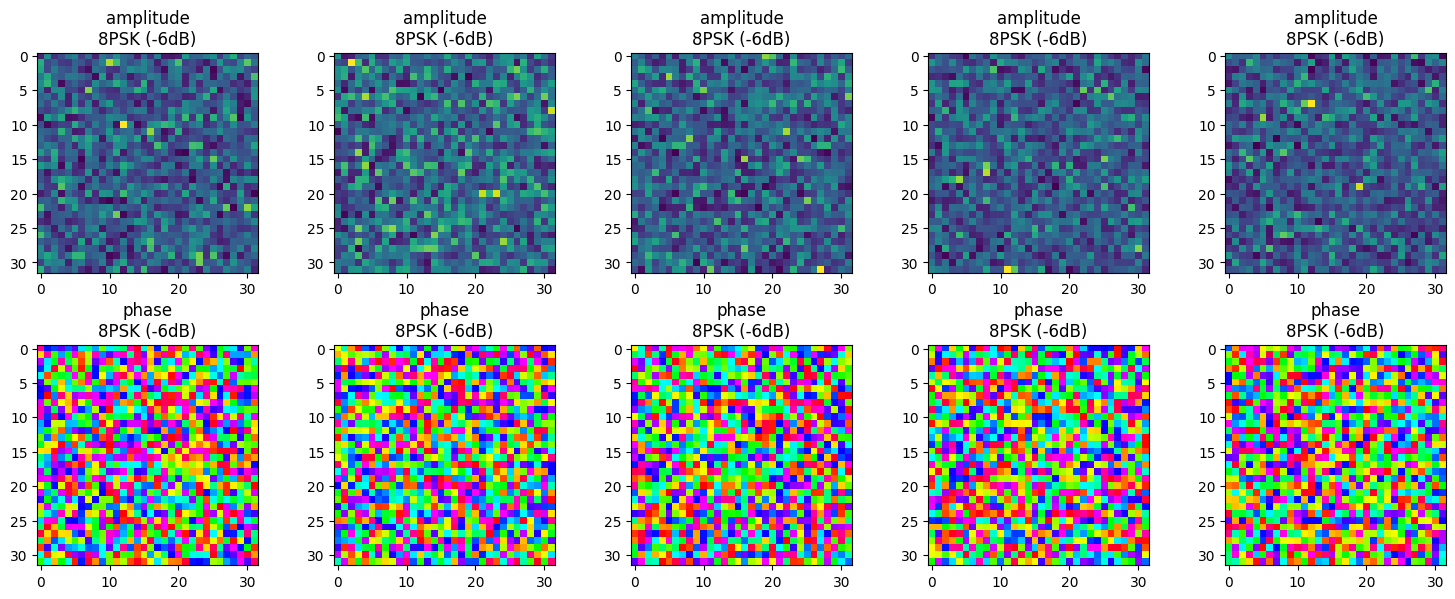

✅ Sample visualization saved


In [35]:
visualize_samples()

In [36]:
def print_dataset_summary():
    """Print summary of processed dataset."""
    
    print(f"\n📋 Dataset Summary:")
    print(f"   Feature method: {FEATURE_METHOD}")
    print(f"   Modulations: {TARGET_MODULATIONS}")
    print(f"   SNR levels: {TARGET_SNRS}")
    print(f"   Output directory: {OUTPUT_DIR}")
    
    # Load and summarize files
    for split in ['train', 'valid']:
        file_path = os.path.join(OUTPUT_DIR, f'{split}_{FEATURE_METHOD}.h5')
        if os.path.exists(file_path):
            with h5py.File(file_path, 'r') as f:
                num_samples = f.attrs['num_samples']
                file_size = os.path.getsize(file_path) / (1024**2)
                
                print(f"   {split.capitalize()}: {num_samples} samples ({file_size:.1f} MB)")
                
                # Show class distribution
                labels = f['labels'][:]
                snrs = f['snrs'][:]
                
                for mod_idx, mod_name in enumerate(TARGET_MODULATIONS):
                    for snr in TARGET_SNRS:
                        count = np.sum((labels == mod_idx) & (snrs == snr))
                        print(f"     {mod_name} @ {snr}dB: {count} samples")



print_dataset_summary()


📋 Dataset Summary:
   Feature method: amplitude_phase
   Modulations: ['8PSK', '16QAM']
   SNR levels: [-6, 6, 18]
   Output directory: ./aplitude_wavelet_xperiment
   Train: 19656 samples (138.6 MB)
     8PSK @ -6dB: 3276 samples
     8PSK @ 6dB: 3276 samples
     8PSK @ 18dB: 3276 samples
     16QAM @ -6dB: 3276 samples
     16QAM @ 6dB: 3276 samples
     16QAM @ 18dB: 3276 samples
   Valid: 4920 samples (34.8 MB)
     8PSK @ -6dB: 820 samples
     8PSK @ 6dB: 820 samples
     8PSK @ 18dB: 820 samples
     16QAM @ -6dB: 820 samples
     16QAM @ 6dB: 820 samples
     16QAM @ 18dB: 820 samples


### *STARTING BUILDING THE TRAINING AND DATA LOAD*

## Configuration

In [4]:
DATA_DIR = OUTPUT_DIR 
BATCH_SIZE = 128
NUM_EPOCHS = 100 
NUM_WORKERS = 0 
NUM_CLASSES = len(TARGET_MODULATIONS)
LEARNING_RATE = 0.01

In [5]:
class CWTDataset(Dataset):
    """Dataset class for loading preprocessed features - adapts to any FEATURE_METHOD."""
    
    def __init__(self, h5_file_path, seed=48):
        """
        Initialize dataset for any preprocessed signal features.
        
        Args:
            h5_file_path: Path to HDF5 file (e.g., 'train_amplitude_phase.h5')
            seed: Random seed (for compatibility with existing code)
        """
        self.file_path = h5_file_path
        self.seed = seed
        
        if not os.path.exists(h5_file_path):
            raise FileNotFoundError(f"HDF5 file not found: {h5_file_path}")
        
        # Open HDF5 file
        self.h5_file = h5py.File(h5_file_path, 'r')
        
        # Auto-detect feature method
        feature_method_raw = self.h5_file.attrs.get('feature_method', 'unknown')
        if isinstance(feature_method_raw, bytes):
            self.feature_method = feature_method_raw.decode('utf-8')
        else:
            self.feature_method = str(feature_method_raw)
        
        # Get dataset references - always 'feature1' and 'feature2' from preprocessing
        self.feature1 = self.h5_file['feature1']  
        self.feature2 = self.h5_file['feature2']  
        self.labels = self.h5_file['labels']
        self.snrs = self.h5_file['snrs']
        
        # Store dataset size
        self.num_samples = self.feature1.shape[0]
        
        # Print dataset info
        print(f"Loaded {self.feature_method} dataset:")
        print(f"  File: {h5_file_path}")
        print(f"  Samples: {self.num_samples}")
        print(f"  Feature1 shape: {self.feature1.shape}")
        print(f"  Feature2 shape: {self.feature2.shape}")
        
        # Get feature names from metadata (with fallback)
        feature1_name_raw = self.h5_file.attrs.get('feature1_name', 'feature1')
        feature2_name_raw = self.h5_file.attrs.get('feature2_name', 'feature2')
        
        # Handle both string and bytes cases
        if isinstance(feature1_name_raw, bytes):
            self.feature1_name = feature1_name_raw.decode('utf-8')
        else:
            self.feature1_name = str(feature1_name_raw)
            
        if isinstance(feature2_name_raw, bytes):
            self.feature2_name = feature2_name_raw.decode('utf-8')
        else:
            self.feature2_name = str(feature2_name_raw)
            
        print(f"  Features: {self.feature1_name}, {self.feature2_name}")
        
    def __len__(self):
        """Return number of samples."""
        return self.num_samples
    
    def __getitem__(self, idx):
        """
        Get a single sample.
        
        Returns:
            feature1: (1, 32, 32) tensor - First feature (amplitude/i_wavelet/fft_real/etc)
            feature2: (1, 32, 32) tensor - Second feature (phase/q_wavelet/fft_imag/etc)  
            label: int - modulation class (0=8PSK, 1=16QAM)
            snr: float - signal-to-noise ratio
        """
        if idx < 0 or idx >= self.num_samples:
            raise IndexError(f"Index {idx} out of range for dataset of size {self.num_samples}")
        
        # Load from HDF5
        feature1 = self.feature1[idx]  # Shape: (32, 32)
        feature2 = self.feature2[idx]  # Shape: (32, 32)
        label = int(self.labels[idx])
        snr = float(self.snrs[idx])
        
        # Convert to PyTorch tensors and add channel dimension
        feature1_tensor = torch.from_numpy(feature1).float().unsqueeze(0)  # (1, 32, 32)
        feature2_tensor = torch.from_numpy(feature2).float().unsqueeze(0)  # (1, 32, 32)
        
        return feature1_tensor, feature2_tensor, label, snr
    
    def get_sample_info(self, idx):
        """Get sample metadata without loading the actual data."""
        label = int(self.labels[idx])
        snr = float(self.snrs[idx])
        
        # Map label to modulation name
        modulations = ['8PSK', '16QAM']
        mod_name = modulations[label] if label < len(modulations) else f'Unknown_{label}'
        
        return {
            'index': idx,
            'label': label,
            'modulation': mod_name,
            'snr': snr
        }
    
    def get_dataset_stats(self):
        """Get dataset statistics."""
        labels = self.labels[:]
        snrs = self.snrs[:]
        
        stats = {
            'total_samples': self.num_samples,
            'modulations': {},
            'snr_levels': {},
            'combinations': {}
        }
        
        # Count by modulation
        modulations = ['8PSK', '16QAM']
        for i, mod in enumerate(modulations):
            stats['modulations'][mod] = int(sum(labels == i))
        
        # Count by SNR
        unique_snrs = sorted(set(snrs))
        for snr in unique_snrs:
            stats['snr_levels'][f'{snr}dB'] = int(sum(snrs == snr))
        
        # Count by combination
        for i, mod in enumerate(modulations):
            for snr in unique_snrs:
                key = f'{mod}_{snr}dB'
                count = int(sum((labels == i) & (snrs == snr)))
                stats['combinations'][key] = count
        
        return stats
    
    def close(self):
        """Close HDF5 file handle."""
        if hasattr(self, 'h5_file') and self.h5_file:
            self.h5_file.close()
    
    def __del__(self):
        """Ensure file cleanup on deletion."""
        self.close()

In [6]:
train_dataset = CWTDataset(
    h5_file_path=os.path.join(DATA_DIR, 'train_amplitude_phase.h5'),
    seed=48
)

valid_dataset = CWTDataset(
    h5_file_path=os.path.join(DATA_DIR, 'valid_amplitude_phase.h5'), 
    seed=48
)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
    pin_memory=True, num_workers=0, persistent_workers=False
)

valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, 
    pin_memory=True, num_workers=0, persistent_workers=False
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")

Loaded amplitude_phase dataset:
  File: ./aplitude_wavelet_xperiment\train_amplitude_phase.h5
  Samples: 19656
  Feature1 shape: (19656, 32, 32)
  Feature2 shape: (19656, 32, 32)
  Features: amplitude, phase
Loaded amplitude_phase dataset:
  File: ./aplitude_wavelet_xperiment\valid_amplitude_phase.h5
  Samples: 4920
  Feature1 shape: (4920, 32, 32)
  Feature2 shape: (4920, 32, 32)
  Features: amplitude, phase
Train dataset size: 19656
Validation dataset size: 4920


In [13]:
# Model 1: Standard CNN-LSTM
try:
    from models.CNN_LSTM_IQ import create_enhanced_CNNLSTMIQModel
    model_standard = create_enhanced_CNNLSTMIQModel(n_labels=NUM_CLASSES, dropout_rate=0.3).to(device)
    print("✅ Successfully built Standard CNN-LSTM Model")
except Exception as e:
    print(f"⚠️ Could not build Standard Model: {e}")

# Model 2: Parallel CNN-LSTM
try:
    from models.CNN_LSTM_IQ_Parallel import create_diagram_iq_model
    model_parallel = create_diagram_iq_model(num_classes=NUM_CLASSES, dropout_rate=0.5).to(device)
    print("✅ Successfully built Parallel CNN-LSTM Model")
except Exception as e:
    print(f"⚠️ Could not build Parallel Model: {e}")

✅ Successfully built Standard CNN-LSTM Model
✅ Successfully built Parallel CNN-LSTM Model


In [14]:
# Shared training components
criterion = nn.CrossEntropyLoss(label_smoothing=0.2).to(device)

optimizer_standard = optim.Adam(model_standard.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
optimizer_parallel = optim.Adam(model_parallel.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)

scheduler_standard = optim.lr_scheduler.ReduceLROnPlateau(optimizer_standard, mode='max', factor=0.5, patience=5)
scheduler_parallel = optim.lr_scheduler.ReduceLROnPlateau(optimizer_parallel, mode='max', factor=0.5, patience=5)

scaler_standard = GradScaler()
scaler_parallel = GradScaler()

In [15]:
# --- Training Metrics Storage ---
metrics = {
    'standard': {
        'train_losses': [], 'valid_losses': [], 
        'train_accuracies': [], 'valid_accuracies': [],
        'training_times': [], 'best_accuracy': 0.0,
        'final_predictions': [], 'final_true_labels': []
    },
    'parallel': {
        'train_losses': [], 'valid_losses': [], 
        'train_accuracies': [], 'valid_accuracies': [],
        'training_times': [], 'best_accuracy': 0.0,
        'final_predictions': [], 'final_true_labels': []
    }
}

In [16]:
# Early stopping
patience_counters = {'standard': 0, 'parallel': 0}
best_models = {'standard': None, 'parallel': None}

In [17]:
def train_epoch(model, train_loader, optimizer, criterion, scaler, device):
    """Training epoch for IQ wavelet features."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (i_wavelet, q_wavelet, labels, snrs) in enumerate(train_loader):
        # Move data to GPU
        i_wavelet = i_wavelet.to(device, non_blocking=True)
        q_wavelet = q_wavelet.to(device, non_blocking=True) 
        labels = labels.to(device, non_blocking=True)
        # Note: snrs not needed for training, just metadata
        
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(i_wavelet, q_wavelet)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Debug GPU usage every 50 batches
        if batch_idx % 50 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1e9
            print(f"Batch {batch_idx}: GPU Memory: {gpu_memory:.2f}GB, Loss: {loss.item():.4f}")
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total
    
    return epoch_loss, epoch_accuracy

def validate_epoch(model, valid_loader, criterion, device):
    """Validation epoch for IQ wavelet features."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i_wavelet, q_wavelet, labels, snrs in valid_loader:
            # Move data to GPU
            i_wavelet = i_wavelet.to(device, non_blocking=True)
            q_wavelet = q_wavelet.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            outputs = model(i_wavelet, q_wavelet)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(valid_loader)
    epoch_accuracy = 100. * correct / total
    
    return epoch_loss, epoch_accuracy

### **START TRAINING**

In [18]:
print(f"\n🚀 Starting dual model training...")
print("=" * 60)
patience = 10 
for epoch in range(NUM_EPOCHS):
    print(f"\n📊 Epoch {epoch+1}/{NUM_EPOCHS}")
    epoch_start = time.time() 
    # Train standard model
    print("   Training standard model...")
    train_loss_std, train_acc_std = train_epoch(
        model_standard, train_loader, optimizer_standard, criterion, scaler_standard, device
    )
    print(f"   ✅ Standard - Train Loss: {train_loss_std:.4f}, Acc: {train_acc_std:.2f}%")
    
    # Train parallel model  
    print("   Training parallel model...")
    train_loss_par, train_acc_par = train_epoch(
        model_parallel, train_loader, optimizer_parallel, criterion, scaler_parallel, device
    )
    print(f"   ✅ Parallel - Train Loss: {train_loss_par:.4f}, Acc: {train_acc_par:.2f}%")
    
    # Validation
    print("   Validating...")
    valid_loss_std, valid_acc_std = validate_epoch(model_standard, valid_loader, criterion, device)
    valid_loss_par, valid_acc_par = validate_epoch(model_parallel, valid_loader, criterion, device)
    
    print(f"   📈 Standard Valid: {valid_acc_std:.2f}% | Parallel Valid: {valid_acc_par:.2f}%")
    
    metrics['standard']['train_losses'].append(train_loss_std)
    metrics['standard']['train_accuracies'].append(train_acc_std)
    metrics['standard']['valid_losses'].append(valid_loss_std)
    metrics['standard']['valid_accuracies'].append(valid_acc_std)
    
    metrics['parallel']['train_losses'].append(train_loss_par)
    metrics['parallel']['train_accuracies'].append(train_acc_par)
    metrics['parallel']['valid_losses'].append(valid_loss_par)
    metrics['parallel']['valid_accuracies'].append(valid_acc_par)
    
    scheduler_standard.step(valid_acc_std)
    scheduler_parallel.step(valid_acc_par)
    
    if valid_acc_std > metrics['standard']['best_accuracy']:
        metrics['standard']['best_accuracy'] = valid_acc_std
        metrics['standard']['patience_counter'] = 0
        torch.save(model_standard.state_dict(), 'best_standard_model.pth')
    else:
        metrics['standard']['patience_counter'] += 1
    
    if valid_acc_par > metrics['parallel']['best_accuracy']:
        metrics['parallel']['best_accuracy'] = valid_acc_par
        metrics['parallel']['patience_counter'] = 0
        torch.save(model_parallel.state_dict(), 'best_parallel_model.pth')
    else:
        metrics['parallel']['patience_counter'] += 1
    
    epoch_time = time.time() - epoch_start
    
    if (epoch + 1) % 5 == 0:
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} ({epoch_time:.2f}s):")
        print(f"Standard  - Train: {train_acc_std:.2f}% | Valid: {valid_acc_std:.2f}% | Loss: {valid_loss_std:.4f}")
        print(f"Parallel  - Train: {train_acc_par:.2f}% | Valid: {valid_acc_par:.2f}% | Loss: {valid_loss_par:.4f}")
        print(f"Best - Standard: {metrics['standard']['best_accuracy']:.2f}% | Parallel: {metrics['parallel']['best_accuracy']:.2f}%")
    
    if min(metrics['standard']['patience_counter'], metrics['parallel']['patience_counter']) >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print(f"\n🎉 Training Complete!")
print(f"Standard Model Best: {metrics['standard']['best_accuracy']:.2f}%")
print(f"Parallel Model Best: {metrics['parallel']['best_accuracy']:.2f}%")

if metrics['standard']['best_accuracy'] > metrics['parallel']['best_accuracy']:
    winner = "Standard"
    margin = metrics['standard']['best_accuracy'] - metrics['parallel']['best_accuracy']
else:
    winner = "Parallel"
    margin = metrics['parallel']['best_accuracy'] - metrics['standard']['best_accuracy']

print(f"🏆 Winner: {winner} model (+{margin:.2f}%)")


🚀 Starting dual model training...

📊 Epoch 1/100
   Training standard model...
Batch 0: GPU Memory: 0.04GB, Loss: 6.5109
Batch 50: GPU Memory: 0.05GB, Loss: 0.5887
Batch 100: GPU Memory: 0.05GB, Loss: 0.4663
Batch 150: GPU Memory: 0.05GB, Loss: 0.4981
   ✅ Standard - Train Loss: 0.8621, Acc: 78.27%
   Training parallel model...
Batch 0: GPU Memory: 0.05GB, Loss: 0.9479
Batch 50: GPU Memory: 0.05GB, Loss: 0.6020
Batch 100: GPU Memory: 0.05GB, Loss: 0.5310
Batch 150: GPU Memory: 0.05GB, Loss: 0.5080
   ✅ Parallel - Train Loss: 0.5468, Acc: 76.74%
   Validating...
   📈 Standard Valid: 77.97% | Parallel Valid: 50.00%

📊 Epoch 2/100
   Training standard model...
Batch 0: GPU Memory: 0.05GB, Loss: 0.4760
Batch 50: GPU Memory: 0.05GB, Loss: 0.4796
Batch 100: GPU Memory: 0.05GB, Loss: 0.4538
Batch 150: GPU Memory: 0.05GB, Loss: 0.4550
   ✅ Standard - Train Loss: 0.4645, Acc: 83.02%
   Training parallel model...
Batch 0: GPU Memory: 0.05GB, Loss: 0.4774
Batch 50: GPU Memory: 0.05GB, Loss: 0.46

KeyboardInterrupt: 

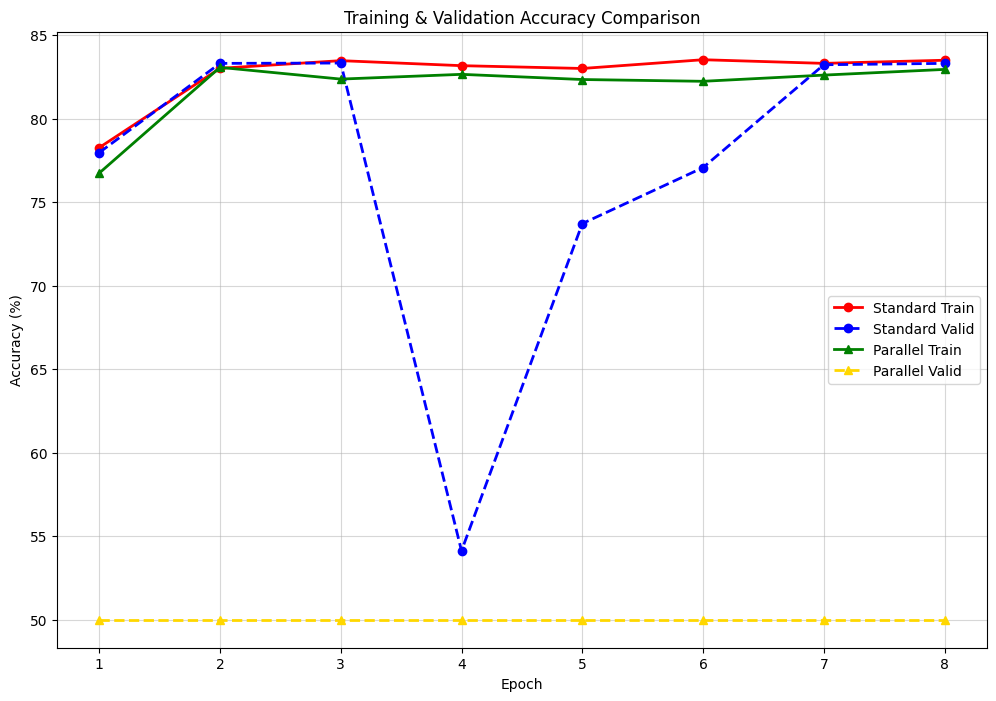

In [21]:
plt.figure(figsize=(12, 8), dpi=100)
plt.plot(epochs, metrics['standard']['train_accuracies'], 'b-', label='Standard Train', linewidth=2,color = 'red',marker = 'o')
plt.plot(epochs, metrics['standard']['valid_accuracies'], 'b--', label='Standard Valid', linewidth=2,color = 'blue', marker = 'o')
plt.plot(epochs, metrics['parallel']['train_accuracies'], 'r-', label='Parallel Train', linewidth=2,color = 'green', marker = '^')
plt.plot(epochs, metrics['parallel']['valid_accuracies'], 'r--', label='Parallel Valid', linewidth=2, color = 'gold', marker = '^')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.5)

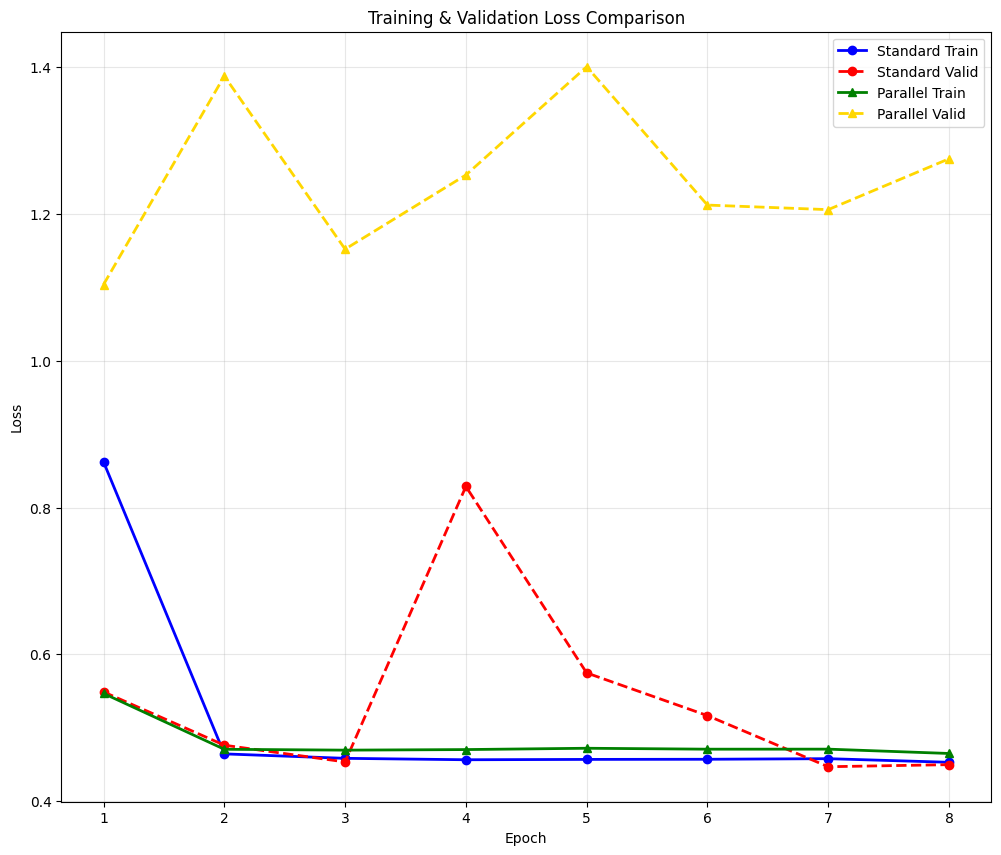

In [20]:
plt.figure(figsize=(12, 10), dpi=100)
epochs = range(1, len(metrics['standard']['train_losses']) + 1)
plt.plot(epochs, metrics['standard']['train_losses'], 'b-', label='Standard Train', linewidth=2,marker = 'o', color = 'blue')
plt.plot(epochs, metrics['standard']['valid_losses'], 'b--', label='Standard Valid', linewidth=2, marker = 'o', color = 'red')
plt.plot(epochs, metrics['parallel']['train_losses'], 'r-', label='Parallel Train', linewidth=2, marker = '^', color = 'green')
plt.plot(epochs, metrics['parallel']['valid_losses'], 'r--', label='Parallel Valid', linewidth=2,marker = '^', color = 'gold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)